# RICERCA IN SPAZI DI STATI

#### Librerie utilizzate

In [18]:
import osmnx as ox
import folium
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import heapq

#### ESTRAZIONE DELLA RETE STRADALE DI BARI nel grafo G

In [ ]:
#Estrazione della rete stradale di Bari
G = ox.graph_from_place("Bari, Italy", network_type="drive", simplify=True)

#Salvare la rete in formato GraphML
ox.save_graphml(G, "rete_bari.graphml")

#### Plot del grafo

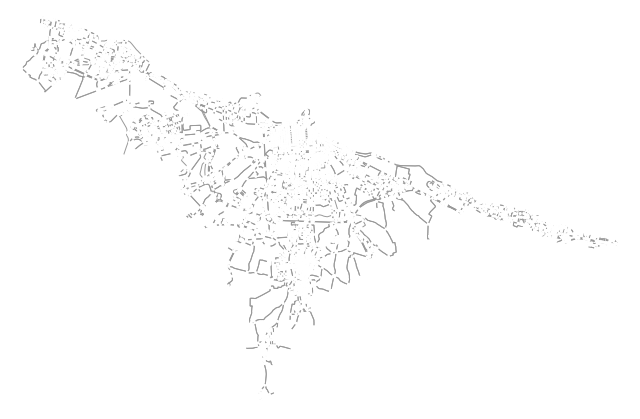

In [3]:
#Disegnare il grafo statico
#Caricare la rete da file GraphML
G = ox.load_graphml("rete_bari.graphml")
fig, ax = ox.plot_graph(G, node_size=5, edge_linewidth=0.7, bgcolor="white")
plt.show()

#### Aggiunta numero incidenti sui segmenti stradali

Sfruttando il dataset **"Dati_aggregati"**, dove per ogni segmento stradale sono presenti il *numero di incidenti* avvenuti, aggiorno gli archi del grafo G con questa informazione

In [ ]:
df = pd.read_csv(".\\Dati\\Dati_aggregati.csv")

incidenti_dict = df.groupby("ID_Segmento")["NUM_INCIDENTI"].sum().to_dict()

for u, v, k, data in G.edges(data=True, keys=True):
    if "osmid" in data:
        osmids = data["osmid"]

        if isinstance(osmids, list):
            incidenti_count = sum(incidenti_dict.get(osmid, 0) for osmid in osmids)
        else:
            incidenti_count = incidenti_dict.get(osmids, 0)

        data["incidenti"] = incidenti_count

ox.save_graphml(G, "rete_bari_incidenti.graphml")
print("Grafo salvato con successo")

#### Script utile a trovare il nodo più vicino a delle coordinate inserite

In [4]:
def get_nearest_node(graph, x, y):
    """Trova il nodo più vicino alle coordinate (x, y) nel grafo."""
    nearest_node = ox.distance.nearest_nodes(graph, X=x, Y=y)
    
    # Ottenere le coordinate del nodo più vicino
    nodes, _ = ox.graph_to_gdfs(graph)
    node_coords = nodes.loc[nearest_node].geometry
    
    return nearest_node, node_coords.y, node_coords.x

# Caricare il grafo di Bari
G = ox.load_graphml("rete_bari_incidenti.graphml")

# Inserire le coordinate di input
x_input = 16.8548679  # Esempio di longitudine   
y_input = 41.1251951  # Esempio di latitudine

# Trovare il nodo più vicino
node_id, lat, lon = get_nearest_node(G, x_input, y_input)

print(f"Nodo più vicino trovato: ID = {node_id}, Latitudine = {lat}, Longitudine = {lon}")



Nodo più vicino trovato: ID = 1481415203, Latitudine = 41.1252559, Longitudine = 16.8548615


## Ricerca con Iterative-Deepening

In [14]:
import osmnx as ox
import time
import sys

def dls(graph, start, goal, depth, explored_paths):
    """Ricerca in profondità limitata (DLS) per IDDFS"""
    stack = [(start, [start])]
    
    while stack:
        node, path = stack.pop()
        explored_paths.append(path)  # Salvare il percorso esplorato
        
        if node == goal:
            return path  # Ritorna il percorso trovato
        
        if len(path) - 1 < depth:  # Controllo della profondità
            for neighbor in graph.neighbors(node):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor]))
    
    return None  # Nessun percorso trovato entro la profondità

def iterative_deepening_dfs(graph, start, goal, max_depth=22):
    """Iterative Deepening DFS per trovare il percorso più breve tra due nodi, registrando statistiche."""
    explored_paths = []
    start_time = time.time()
    memory_before = sys.getsizeof(explored_paths)
    
    for depth in range(max_depth):
        result = dls(graph, start, goal, depth, explored_paths)
        if result:
            execution_time = time.time() - start_time
            memory_after = sys.getsizeof(explored_paths)
            memory_used = memory_after - memory_before
            return result, explored_paths, depth, execution_time, memory_used  # Restituisce il percorso, profondità, tempo e memoria
    
    execution_time = time.time() - start_time
    memory_after = sys.getsizeof(explored_paths)
    memory_used = memory_after - memory_before
    return None, explored_paths, max_depth, execution_time, memory_used  # Nessun percorso trovato

# Caricare il grafo di Bari
G = ox.load_graphml("rete_bari_incidenti.graphml")

partenza = 270659688
arrivo = 1481415203

# Trovare il percorso più breve tra i due nodi e raccogliere statistiche
shortest_path, explored_paths, depth_reached, exec_time, memory_used = iterative_deepening_dfs(G, partenza, arrivo)

if shortest_path:
    print(f"Percorso più breve trovato: {shortest_path}")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")
else:
    print("Nessun percorso trovato.")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")


Percorso più breve trovato: [270659688, 270388628, 322548994, 322549051, 322550079, 322549607, 322550392, 322550761, 320970977, 330655154, 330655155, 270388358, 320971935, 320971934, 270437927, 353330854, 270389790, 329988604, 329988602, 270655174, 270654641, 1481415203]
Profondità raggiunta: 21
Tempo di esecuzione: 0.0503 secondi
Memoria utilizzata: 562432 byte


### Ottimizzazione dell'algoritmo IDDFS: Riduzione delle riesplorazioni ridondanti

#### **Problematica**
L'algoritmo **Iterative Deepening Depth-First Search (IDDFS)**, nella sua implementazione standard, può riesplorare più volte lo stesso nodo con percorsi di lunghezza maggiore rispetto a quelli già individuati. Questa caratteristica comporta un incremento del numero di iterazioni, del tempo di esecuzione e dell'uso della memoria, soprattutto in grafi di grandi dimensioni.

#### **Soluzione Implementata**
Per ottimizzare l'algoritmo, è stato introdotto un **dizionario `visited`**, che tiene traccia della profondità minima a cui ogni nodo è stato raggiunto. Il comportamento dell'algoritmo è stato modificato nel seguente modo:
- Se un nodo viene raggiunto con una profondità maggiore rispetto a quella con cui era stato precedentemente visitato, viene **ignorato**.
- Se un nodo viene raggiunto per la **prima volta** o con una **profondità inferiore**, la sua profondità viene aggiornata in `visited[node]`, garantendo che l'algoritmo utilizzi sempre il percorso più breve disponibile.

#### **Benefici dell'Ottimizzazione**
- **Riduzione del numero di riesplorazioni**, evitando di considerare percorsi subottimali.  
- **Miglioramento del tempo di esecuzione**, specialmente in grafi di grandi dimensioni.  
- **Ottimizzazione dell'uso della memoria**, limitando la crescita dello stack di ricerca.  
- **Mantenimento della correttezza dell'algoritmo**, preservando la capacità di individuare il percorso minimo.

L'ottimizzazione implementata consente di ottenere una versione più **efficiente e scalabile** dell'algoritmo IDDFS, particolarmente adatta per l'esplorazione di grafi di grandi dimensioni e applicazioni real-time.


In [16]:
def dls(graph, start, goal, depth, explored_paths, visited):
    """Ricerca in profondità limitata (DLS) per IDDFS evitando riesplorazioni."""
    stack = [(start, [start])]
    
    while stack:
        node, path = stack.pop()
        
        if node in visited and len(path) - 1 > visited[node]:
            continue  # Se il nodo è già stato visitato con un percorso più breve, lo saltiamo
        
        visited[node] = len(path) - 1  # Aggiorniamo il livello minimo raggiunto per questo nodo
        explored_paths.append(path)  # Salvare il percorso esplorato
        
        if node == goal:
            return path  # Ritorna il percorso trovato
        
        if len(path) - 1 < depth:  # Controllo della profondità
            for neighbor in graph.neighbors(node):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor]))
    
    return None  # Nessun percorso trovato entro la profondità

def iterative_deepening_dfs(graph, start, goal, max_depth=50):
    """Iterative Deepening DFS per trovare il percorso più breve tra due nodi evitando riesplorazioni."""
    explored_paths = []
    start_time = time.time()
    memory_before = sys.getsizeof(explored_paths)
    
    visited = {}  # Dizionario per tracciare la profondità minima raggiunta per ogni nodo
    
    for depth in range(max_depth):
        result = dls(graph, start, goal, depth, explored_paths, visited)
        if result:
            execution_time = time.time() - start_time
            memory_after = sys.getsizeof(explored_paths)
            memory_used = memory_after - memory_before
            return result, explored_paths, depth, execution_time, memory_used  # Restituisce il percorso, profondità, tempo e memoria
    
    execution_time = time.time() - start_time
    memory_after = sys.getsizeof(explored_paths)
    memory_used = memory_after - memory_before
    return None, explored_paths, max_depth, execution_time, memory_used  # Nessun percorso trovato

# Caricare il grafo di Bari
G = ox.load_graphml("rete_bari_incidenti.graphml")

partenza = 270659688
arrivo = 1481415203

# Trovare il percorso più breve tra i due nodi e raccogliere statistiche
shortest_path, explored_paths, depth_reached, exec_time, memory_used = iterative_deepening_dfs(G, partenza, arrivo)

if shortest_path:
    print(f"Percorso più breve trovato: {shortest_path}")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")
else:
    print("Nessun percorso trovato.")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")


Percorso più breve trovato: [270659688, 270388628, 322548994, 322549051, 322550079, 322549607, 322550392, 322550761, 320970977, 330655154, 330655155, 270388358, 320971935, 320971934, 270437927, 353330854, 270389790, 329988604, 329988602, 270655174, 270654641, 1481415203]
Profondità raggiunta: 21
Tempo di esecuzione: 0.0134 secondi
Memoria utilizzata: 67168 byte


In [21]:
def plot_paths_on_map(graph, shortest_path, explored_paths, start, goal):
    """Visualizza i percorsi esplorati e il percorso più breve sulla mappa con marker ottimizzati"""
    nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
    center = (nodes.loc[start].geometry.y, nodes.loc[start].geometry.x)
    
    mappa = folium.Map(location=center, zoom_start=13)
    
    # Disegnare un sottoinsieme dei percorsi esplorati in blu
    sampled_paths = explored_paths[::max(1, len(explored_paths) // 500)]  # Campiona percorsi per ottimizzare il rendering
    for path in sampled_paths:
        path_coords = [(nodes.loc[node].geometry.y, nodes.loc[node].geometry.x) for node in path]
        folium.PolyLine(path_coords, color="blue", weight=4, opacity=0.5).add_to(mappa)
    
    # Disegnare il percorso più breve in rosso sopra il blu
    if shortest_path:
        path_coords = [(nodes.loc[node].geometry.y, nodes.loc[node].geometry.x) for node in shortest_path]
        folium.PolyLine(path_coords, color="red", weight=6, opacity=0.9).add_to(mappa)
    
    # Aggiungere marker per il punto di partenza e di arrivo
    folium.Marker(
        location=(nodes.loc[start].geometry.y, nodes.loc[start].geometry.x),
        popup="Partenza",
        icon=folium.Icon(color="green", icon="play")
    ).add_to(mappa)
    
    folium.Marker(
        location=(nodes.loc[goal].geometry.y, nodes.loc[goal].geometry.x),
        popup="Arrivo",
        icon=folium.Icon(color="red", icon="flag")
    ).add_to(mappa)
    
    return mappa

# Visualizzare i percorsi sulla mappa
if shortest_path:
    print(f"Percorso più breve trovato: {shortest_path}")
    mappa_percorso = plot_paths_on_map(G, shortest_path, explored_paths, partenza, arrivo)
    mappa_percorso.save("mappa_percorso.html")
    print("\nApri 'mappa_percorso.html' per visualizzare i percorsi esplorati e il più breve sulla mappa.")
else:
    print("Nessun percorso trovato.")

Percorso più breve trovato: [270659688, 270388628, 322548994, 322548996, 12083787147, 569212252, 3860917204, 3841272949, 3860940020, 330076413, 279650482, 1483634369, 1483634284, 279655605, 280884748, 279380962, 339607009, 279655525, 10680697917, 316572227, 10680697906, 279655521, 9602691583, 1014703348, 1249973250, 4395827572, 5395447618, 5395447592, 5395448236, 5395447590, 330932109, 1459966804, 298502133, 329994613, 330003439, 1481415203]

Apri 'mappa_percorso.html' per visualizzare i percorsi esplorati e il più breve sulla mappa.


## LOWEST COST-FIRST SEARCH 

In [ ]:
import heapq
import osmnx as ox
import time
import sys

def lowest_cost_first_search(graph, start, goal):
    """Implementa la ricerca Lowest-Cost-First basata sul numero di incidenti."""
    
    # Coda di priorità per gestire i percorsi con il costo minore
    priority_queue = [(0, start, [start])]  # (costo cumulativo, nodo attuale, percorso)
    visited = {}  # Dizionario per memorizzare il miglior costo trovato per ciascun nodo
    explored_paths = 0  # Conta i percorsi visitati
    start_time = time.time()
    memory_before = sys.getsizeof(priority_queue) + sys.getsizeof(visited)
    max_depth = 0
    
    while priority_queue:
        cost, node, path = heapq.heappop(priority_queue)  # Estrai il nodo con il minor costo
        explored_paths += 1
        max_depth = max(max_depth, len(path) - 1)
        
        if node == goal:
            execution_time = time.time() - start_time
            memory_after = sys.getsizeof(priority_queue) + sys.getsizeof(visited)
            memory_used = memory_after - memory_before
            return path, cost, explored_paths, execution_time, memory_used, max_depth  # Restituisce i risultati
        
        if node in visited and cost >= visited[node]:
            continue  # Se il nodo è già stato visitato con un costo inferiore, lo ignoriamo
        
        visited[node] = cost  # Memorizza il costo minimo per raggiungere questo nodo
        
        for neighbor in graph.neighbors(node):
            edge_data = graph.get_edge_data(node, neighbor)
            
            # Gestione di archi multipli tra due nodi
            if isinstance(edge_data, dict):
                edge_data = min(edge_data.values(), key=lambda d: d.get("incidenti", float('inf')))
            
            edge_cost = int(edge_data.get("incidenti", 0))  # Converte il valore in intero
            new_cost = cost + edge_cost
            heapq.heappush(priority_queue, (new_cost, neighbor, path + [neighbor]))
    
    execution_time = time.time() - start_time
    memory_after = sys.getsizeof(priority_queue) + sys.getsizeof(visited)
    memory_used = memory_after - memory_before
    return None, float('inf'), explored_paths, execution_time, memory_used, max_depth  # Nessun percorso trovato

# Caricare il grafo con il numero di incidenti sugli archi
G = ox.load_graphml("rete_bari_incidenti.graphml")

partenza = 270659688
arrivo = 1481415203

# Eseguire la ricerca Lowest-Cost-First basata sugli incidenti
shortest_path, min_incidents, explored_paths, exec_time, memory_used, max_depth = lowest_cost_first_search(G, partenza, arrivo)

if shortest_path:
    print(f"Percorso con il minor numero di incidenti trovato: {shortest_path}")
    print(f"Numero totale di incidenti lungo il percorso: {min_incidents}")
    print(f"Numero di percorsi visitati: {explored_paths}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")
    print(f"Profondità massima raggiunta: {max_depth}")
else:
    print("Nessun percorso trovato.")
    print(f"Numero di percorsi visitati: {explored_paths}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")
    print(f"Profondità massima raggiunta: {max_depth}")

Percorso con il minor numero di incidenti trovato: [270659688, 270388628, 322548994, 322548996, 12083787147, 569212252, 3860917204, 3841272949, 3860940020, 330076413, 279650482, 1483634369, 1483634284, 279655605, 280884748, 279380962, 339607009, 279655525, 10680697917, 316572227, 10680697906, 279655521, 9602691583, 1014703348, 1249973250, 4395827572, 5395447618, 5395447592, 5395448236, 5395447590, 330932109, 1459966804, 298502133, 329994613, 330003439, 1481415203]
Numero totale di incidenti lungo il percorso: 123
